In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import sys
import numpy as np
from tqdm import tqdm
import fasttext
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

data_dir = '../../data/recommendation'

# Loading data

In [2]:
books = pd.read_csv(os.path.join(data_dir, 'Books.csv')).dropna()

books.info()
books.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271354 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271354 non-null  object
 1   Book-Title           271354 non-null  object
 2   Book-Author          271354 non-null  object
 3   Year-Of-Publication  271354 non-null  object
 4   Publisher            271354 non-null  object
 5   Image-URL-S          271354 non-null  object
 6   Image-URL-M          271354 non-null  object
 7   Image-URL-L          271354 non-null  object
dtypes: object(8)
memory usage: 18.6+ MB


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# Data analysis and processing

In [3]:
num_classes = 4

title = books[['Book-Title']].rename(columns={'Book-Title':'text'}).astype(str)
title['label'] = ['__label__0' for i in range(title.shape[0])]

author = books[['Book-Author']].rename(columns={'Book-Author':'text'}).astype(str)
author['label'] = ['__label__1' for i in range(author.shape[0])]

publisher = books[['Publisher']].rename(columns={'Publisher':'text'}).astype(str)
publisher['label'] = ['__label__2' for i in range(publisher.shape[0])]

# genre = 
# genre['label'] = [2 for i in range(publisher.shape[0])]

df = pd.concat([title, author, publisher], axis=0)
# df['text'] = df['text'].apply(lambda x: ' '.join(simple_preprocess(x)))
df.head()

,text,label
0,Classical Mythology,__label__0
1,Clara Callan,__label__0
2,Decision in Normandy,__label__0
3,Flu: The Story of the Great Influenza Pandemic...,__label__0
4,The Mummies of Urumchi,__label__0


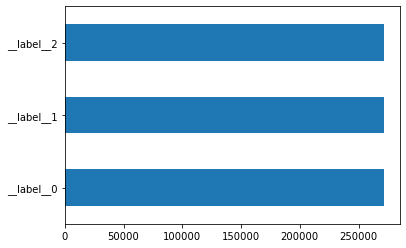

In [4]:
df['label'].value_counts().sort_values().plot(kind='barh')
plt.show()

In [5]:
train, test = train_test_split(df, test_size=0.25, stratify = df['label'], random_state=0)

In [6]:
train.to_csv(os.path.join(data_dir,'train.txt'), index = False,sep = ' ', header = None, quoting = csv.QUOTE_NONE,
             quotechar = "", escapechar = " ")
test.to_csv(os.path.join(data_dir,'test.txt'), index = False,sep = ' ', header = None, quoting = csv.QUOTE_NONE,
             quotechar = "", escapechar = " ")

In [7]:
model = fasttext.train_supervised(input=os.path.join(data_dir,'train.txt'),
                                  lr=0.01,              # learning rate [0.1]
                                  dim=300,             # size of word vectors [100]
                                  ws=5,                # size of the context window [5]
                                  epoch=5,             # number of epochs [5]
                                  minCount=1,          # minimal number of word occurences [1]
                                  minCountLabel=1,     # minimal number of label occurences [1]
                                  minn=0,              # min length of char ngram [0]
                                  maxn=5,              # max length of char ngram [0]
                                  neg=4,               # number of negatives sampled [5]
                                  wordNgrams=4,        # max length of word ngram [1]
                                  loss='softmax',      # loss function {ns, hs, softmax, ova} [softmax]
                                  bucket=2000000,      # number of buckets [2000000]
                                  lrUpdateRate=100,    # change the rate of updates for the learning rate [100]
                                  t=0.0001,            # sampling threshold [0.0001]
                                  verbose=2, # verbose [2]
                                  )
# model.save_model("model_fasttext.bin")

In [8]:
res = model.test(os.path.join(data_dir,'test.txt'))

precision,recall = res[1], res[2]
fscore = 2 * ((precision *recall) / (precision + recall))
print(fscore)

0.9683759507851962


In [9]:
model.quantize(input=os.path.join(data_dir,'train.txt'), retrain=True)
# model.save_model("model_fasttext.ftz")
res = model.test(os.path.join(data_dir,'test.txt'))

precision,recall = res[1], res[2]
fscore = 2 * ((precision *recall) / (precision + recall))
print(fscore)

0.9655162247685686


In [10]:
# model.predict("Which baking dish is best to bake a banana bread ?", k=-1, threshold=0.5)